In [ ]:
!pip install fastai==2.4

In [ ]:
from fastai.data.external import untar_data, URLs

DATASET_PATH = untar_data(URLs.COCO_SAMPLE)
DATASET_PATH = str(DATASET_PATH) + "/train_sample"

In [41]:
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import glob

from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import time

import numpy as np

PATH = DATASET_PATH
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Metrics:
	def __init__(self):
		self.reset()

	def reset(self):
		self.count, self.avg, self.sum = [0.] * 3

	def update(self, val, count=1):
		self.count += count
		self.sum += count * val
		self.avg = self.sum / self.count


def create_loss_meters():
	loss_discriminator_fake = Metrics()
	loss_discriminator_real = Metrics()
	loss_discriminator = Metrics()
	loss_generator_GAN = Metrics()
	loss_generator_L1 = Metrics()
	loss_generator = Metrics()

	return {'loss_discriminator_fake': loss_discriminator_fake,
			'loss_discriminator_real': loss_discriminator_real,
			'loss_discriminator': loss_discriminator,
			'loss_generator_GAN': loss_generator_GAN,
			'loss_generator_L1': loss_generator_L1,
			'loss_generator': loss_generator}


def update_losses(model, loss_meter_dict, count):
	for loss_name, loss_meter in loss_meter_dict.items():
		loss = getattr(model, loss_name)
		loss_meter.update(loss.item(), count=count)

LIGHTNESS = 'lightness'
AB_CHANNELS = 'ab_channels'

def lab_to_rgb(L, ab):
	"""
    Takes a batch of images
    """

	L = (L + 1.) * 50.
	ab = ab * 110.
	Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
	rgb_imgs = []
	for img in Lab:
		img_rgb = lab2rgb(img)
		rgb_imgs.append(img_rgb)
	return np.stack(rgb_imgs, axis=0)


def show_results(model, data, save=True):
	model.net_G.eval()
	with torch.no_grad():
		model.setup_input(data)
		model.forward()
	model.net_G.train()
	fake_color = model.fake_color.detach()
	real_color = model.ab_channels
	L = model.lightness
	fake_imgs = lab_to_rgb(L, fake_color)
	real_imgs = lab_to_rgb(L, real_color)
	fig = plt.figure(figsize=(16, 8))
	for i in range(5):
		ax = plt.subplot(3, 5, i + 1)
		ax.imshow(L[i][0].cpu(), cmap='gray')
		ax.axis("off")
		ax = plt.subplot(3, 5, i + 1 + 5)
		ax.imshow(fake_imgs[i])
		ax.axis("off")
		ax = plt.subplot(3, 5, i + 1 + 10)
		ax.imshow(real_imgs[i])
		ax.axis("off")
	plt.show()
	if save:
		fig.savefig(f"colorization_{time.time()}.png")


def log_results(loss_meter_dict):
	for loss_name, loss_meter in loss_meter_dict.items():
		print(f"{loss_name}: {loss_meter.avg:.5f}")


SIZE = 256
TRAIN_TRANSFORM = 'train'
VALIDATION_TRANSFORM = 'validation'

class ColorizationDataset(Dataset):
	def __init__(self, paths, split=TRAIN_TRANSFORM):
		if split == TRAIN_TRANSFORM:
			self.transforms = transforms.Compose([transforms.Resize((SIZE, SIZE), Image.BICUBIC), transforms.RandomHorizontalFlip()])
		elif split == VALIDATION_TRANSFORM:
			self.transforms = transforms.Resize((SIZE, SIZE), Image.BICUBIC)

		self.split = split
		self.size = SIZE
		self.paths = paths

	def __getitem__(self, idx):
		img = Image.open(self.paths[idx]).convert("RGB")
		img = self.transforms(img)
		img = np.array(img)
		img_lab = rgb2lab(img).astype("float32")
		img_lab = transforms.ToTensor()(img_lab)
		lightness = img_lab[[0], ...] / 50. - 1.
		ab_channels = img_lab[[1, 2], ...] / 110.

		return {LIGHTNESS: lightness, AB_CHANNELS: ab_channels}

	def __len__(self):
		return len(self.paths)


paths = glob.glob(PATH + "/*.jpg")
paths_subset = np.random.choice(paths, 10000, replace=False)
random_indexes = np.random.permutation(10000)

train_paths = paths_subset[random_indexes[:8000]] # The first 8000 images

val_paths = paths_subset[random_indexes[8000:]] # The remaining 2000 images
print(len(train_paths), len(val_paths))

DEFAULT_BATCH_SIZE = 16
NUMBER_OF_WORKERS = 2

def create_data_loader(batch_size=DEFAULT_BATCH_SIZE, n_workers=NUMBER_OF_WORKERS, pin_memory=True, **kwargs):
	return DataLoader(ColorizationDataset(**kwargs), batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)

training_data_loader = create_data_loader(paths=train_paths, split=TRAIN_TRANSFORM)


def build_res_unet(n_input=1, n_output=2, size=256):
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
	return DynamicUnet(body, n_output, (size, size)).to(device)


def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
	for e in range(epochs):
		loss_meter = Metrics()

		for data in tqdm(train_dl): # Iteration with loading
			lightness, ab_channels = data[LIGHTNESS].to(DEVICE), data[AB_CHANNELS].to(DEVICE)
			preds = net_G(lightness)
			loss = criterion(preds, ab_channels)
			opt.zero_grad()
			loss.backward()
			opt.step()

			loss_meter.update(loss.item(), lightness.size(0))

		print(f"Epoch {e + 1}/{epochs}")
		print(f"L1 Loss: {loss_meter.avg:.5f}")


8000 2000


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Training generator

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, training_data_loader, opt, criterion, 20)
# torch.save(net_G.state_dict(), "res18-unet.pt")

In [20]:
class MainModel(nn.Module):
	def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
				 beta1=0.5, beta2=0.999, lambda_L1=100.):
		super().__init__()

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.lambda_L1 = lambda_L1

		if net_G is None:
			self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
		else:
			self.net_G = net_G.to(self.device)
		self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
		self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
		self.L1criterion = nn.L1Loss()
		self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
		self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

	def set_requires_grad(self, model, requires_grad=True):
		for p in model.parameters():
			p.requires_grad = requires_grad

	def setup_input(self, data):
		self.lightness = data[LIGHTNESS].to(self.device)
		self.ab_channels = data[AB_CHANNELS].to(self.device)

	def forward(self):
		self.fake_color = self.net_G(self.lightness)

	def backward_D(self):
		fake_image = torch.cat([self.lightness, self.fake_color], dim=1)
		fake_preds = self.net_D(fake_image.detach())
		self.loss_D_fake = self.GANcriterion(fake_preds, False)
		real_image = torch.cat([self.lightness, self.ab_channels], dim=1)
		real_preds = self.net_D(real_image)
		self.loss_D_real = self.GANcriterion(real_preds, True)
		self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
		self.loss_D.backward()

	def backward_G(self):
		fake_image = torch.cat([self.lightness, self.fake_color], dim=1)
		fake_preds = self.net_D(fake_image)
		self.loss_G_GAN = self.GANcriterion(fake_preds, True)
		self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab_channels) * self.lambda_L1
		self.loss_G = self.loss_G_GAN + self.loss_G_L1
		self.loss_G.backward()

	def optimize(self):
		self.forward()
		self.net_D.train()
		self.set_requires_grad(self.net_D, True)
		self.opt_D.zero_grad()
		self.backward_D()
		self.opt_D.step()

		self.net_G.train()
		self.set_requires_grad(self.net_D, False)
		self.opt_G.zero_grad()
		self.backward_G()
		self.opt_G.step()


def init_weights(net, init='norm', gain=0.02):
	def init_func(m):
		classname = m.__class__.__name__
		if hasattr(m, 'weight') and 'Conv' in classname:
			if init == 'norm':
				nn.init.normal_(m.weight.data, mean=0.0, std=gain)
			elif init == 'xavier':
				nn.init.xavier_normal_(m.weight.data, gain=gain)
			elif init == 'kaiming':
				nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

			if hasattr(m, 'bias') and m.bias is not None:
				nn.init.constant_(m.bias.data, 0.0)
		elif 'BatchNorm2d' in classname:
			nn.init.normal_(m.weight.data, 1., gain)
			nn.init.constant_(m.bias.data, 0.)

	net.apply(init_func)
	print(f"model initialized with {init} initialization")
	return net


def init_model(model, device):
	model = model.to(device)
	model = init_weights(model)
	return model


class PatchDiscriminator(nn.Module):
	def __init__(self, input_c, num_filters=64, n_down=3):
		super().__init__()
		model = [self.get_layers(input_c, num_filters, norm=False)]
		model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down - 1) else 2) for i in range(n_down)]
		model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
		self.model = nn.Sequential(*model)

	def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
		layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
		if norm:
			layers += [nn.BatchNorm2d(nf)]
		if act:
			layers += [nn.LeakyReLU(0.2, True)]
		return nn.Sequential(*layers)

	def forward(self, x):
		return self.model(x)


class GANLoss(nn.Module):
	def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
		super().__init__()
		self.register_buffer('real_label', torch.tensor(real_label))
		self.register_buffer('fake_label', torch.tensor(fake_label))
		if gan_mode == 'vanilla':
			self.loss = nn.BCEWithLogitsLoss()
		elif gan_mode == 'lsgan':
			self.loss = nn.MSELoss()

	def get_labels(self, preds, target_is_real):
		if target_is_real:
			labels = self.real_label
		else:
			labels = self.fake_label
		return labels.expand_as(preds)

	def __call__(self, preds, target_is_real):
		labels = self.get_labels(preds, target_is_real)
		loss = self.loss(preds, labels)
		return loss

Training model

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
	data = next(iter(val_dl))
	for e in range(epochs):
		loss_meter_dict = create_loss_meters()
		i = 0
		for data in tqdm(train_dl):
			model.setup_input(data)
			model.optimize()
			update_losses(model, loss_meter_dict, count=data[LIGHTNESS].size(0))
			i += 1
			if i % display_every == 0:
				print(f"\nEpoch {e + 1}/{epochs}")
				print(f"Iteration {i}/{len(train_dl)}")
				log_results(loss_meter_dict)
				show_results(model, data, save=False)


val_dl = create_data_loader(paths=val_paths, split=VALIDATION_TRANSFORM)

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=DEVICE))
model = MainModel(net_G=net_G)
train_model(model, training_data_loader, 20)
torch.save(model.state_dict(), "final_model.pt")

In [ ]:
model.eval()

Loading model

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=DEVICE))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_model.pt", map_location=DEVICE))

Images taken from LabelMe-12-50k

In [ ]:
path_to = "/content/"
paths = [
         path_to + "000000.jpg",
         path_to + "000001.jpg",
         path_to + "000002.jpg",
         path_to + "000003.jpg",
         path_to + "000004.jpg"
]

test_data_loader = create_data_loader(paths=paths, split=TRAIN_TRANSFORM)

In [33]:
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab_channels
    L = model.lightness
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

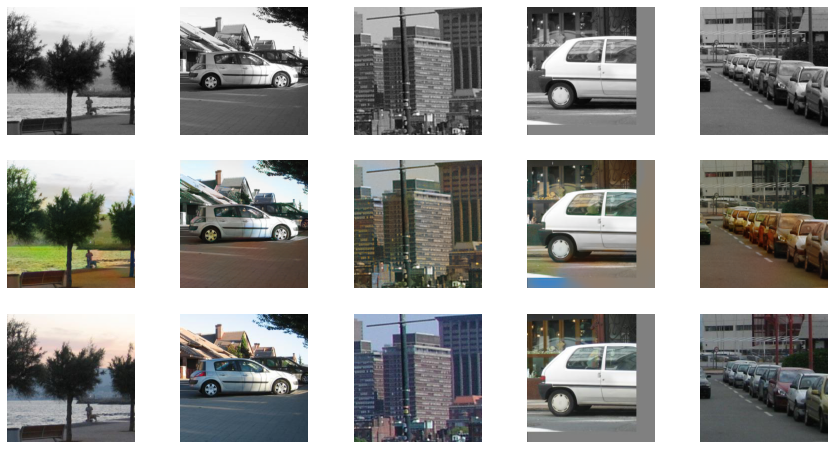

In [44]:
visualize(model, next(iter(test_data_loader)))